In [8]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import skimage.color
import random
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img, array_to_img


In [9]:
fill_mode = 'constant'
#Data generators

original_datagen = ImageDataGenerator()
rotation_datagen = ImageDataGenerator(rotation_range=45, fill_mode = 'constant')
horizontal_datagen = ImageDataGenerator(horizontal_flip=True)
vertical_datagen = ImageDataGenerator(vertical_flip=True)
zoom_datagen = ImageDataGenerator(zoom_range=[0.8, 1.25], fill_mode = 'constant')
shear_datagen = ImageDataGenerator(shear_range=45, fill_mode = 'constant')
height_datagen = ImageDataGenerator(height_shift_range=0.3, fill_mode = 'constant')
width_datagen = ImageDataGenerator(width_shift_range=0.3, fill_mode = 'constant')
brightness_datagen = ImageDataGenerator(brightness_range=[0.1, 2], fill_mode = 'constant')

data_generators = [
    original_datagen,
    horizontal_datagen,
    vertical_datagen,
    rotation_datagen,
    zoom_datagen, 
    shear_datagen, 
    height_datagen,
    width_datagen,
    brightness_datagen,     
]

# Define the list of augmentation techniques
augmentations = [
    'original', 
    'flip_horizontal', 
    'flip_vertical', 
    'rotate', 
    'zoom_range',
    'shear_range',
    'width_shift',
    'height_shift',
    'brightness_jitter',
    'saturation_jitter',
    'hue_jitter', 
    'contrast_jitter'    
]


def saturation_jitter(img):
    # Convert the image to a numpy array
    img_array = np.array(img) / 255.0

    # Convert the image to the HSV color space
    hsv = skimage.color.rgb2hsv(img_array)

    # Generate a random saturation jitter value between 0.2 and 3
    saturation_jitter = np.random.uniform(0.2, 3)

    # Apply the saturation jitter to the saturation channel of the image
    hsv[..., 1] *= saturation_jitter

    # Clip the saturation channel values between 0 and 1
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 1)

    # Convert the image back to the RGB color space
    img_array = skimage.color.hsv2rgb(hsv)
    
    return img_array

def hue_jitter(img):
    # Convert the image to a numpy array
    img_arr = img_to_array(img)

    # Convert the image to the HSV color space
    img_hsv = matplotlib.colors.rgb_to_hsv(img_arr.astype(float)/255)

    # Define the range for the hue jitter
    hue_jitter_range = [0, 0.5]

    # Generate a random hue jitter value within the range
    hue_jitter = random.uniform(hue_jitter_range[0], hue_jitter_range[1])

    # Apply the hue jitter to the hue channel of the image
    img_hsv[..., 0] += hue_jitter

    # Wrap the values of the hue channel to keep them between 0 and 1
    img_hsv[..., 0][img_hsv[..., 0] > 1] -= 1
    img_hsv[..., 0][img_hsv[..., 0] < 0] += 1

    # Convert the image back to the RGB color space
    img_jittered = matplotlib.colors.hsv_to_rgb(img_hsv)*255
    
     # Convert the image back to a PIL Image
    img_jittered = img_jittered.astype(np.uint8)
    
    return img_jittered


def contrast_jitter(img):
   # Convert the image to a numpy array
    img_arr = img_to_array(img)

    # Define the range for the contrast jitter
    contrast_range = [0.5, 2]

    # Generate a random contrast jitter factor within the range
    contrast_factor = random.uniform(contrast_range[0], contrast_range[1])

    # Apply the contrast jitter to the image
    img_jittered = (img_arr - 127.5) * contrast_factor + 127.5

    # Clip the pixel values between 0 and 255
    img_jittered = np.clip(img_jittered, 0, 255)

    # Convert the image back to a PIL Image
    img_jittered = img_jittered.astype(np.uint8)
    return img_jittered

def vertical_flip(img):
    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Vertically flip the image
    img_array_flipped = img_array[::-1, :, :]

    # Convert the numpy array back to an image
    img_flipped = array_to_img(img_array_flipped)
    
    return img_flipped

def horizontal_flip(img):
    # Convert the image to a numpy array
    img_arr = img_to_array(img)

    # Apply horizontal flip to the image using tf.image.flip_left_right
    img_arr_flipped = tf.image.flip_left_right(img_arr)

    # Convert the flipped image array back to an image object
    img_flipped = tf.keras.preprocessing.image.array_to_img(img_arr_flipped)
    
    return img_flipped



def augment_with_datagenerator(technique, img):
    index = augmentations.index(technique)
    datagen = data_generators[index]
    # Reshape the image to 4D array
    data = img_to_array(img)
    sample = np.expand_dims(data, 0)
    aug_iter = datagen.flow(sample, batch_size=1)
    
    batch = aug_iter.next()
    image = batch[0].astype('uint8')
    return image


# Define the augmentation function
def augment_image(technique, img):    
    if (technique == 'saturation_jitter'):
        augmented_img = saturation_jitter(img)
    elif (technique == 'hue_jitter'):
        augmented_img = hue_jitter(img)
    elif (technique == 'contrast_jitter'):
        augmented_img = contrast_jitter(img)
    elif (technique == 'flip_vertical'):
        augmented_img = vertical_flip(img)
    elif (technique == 'flip_horizontal'):
        augmented_img = horizontal_flip(img)
    else:
        augmented_img = augment_with_datagenerator(technique, img)
    return augmented_img


2023-04-18 16:36:49.893475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


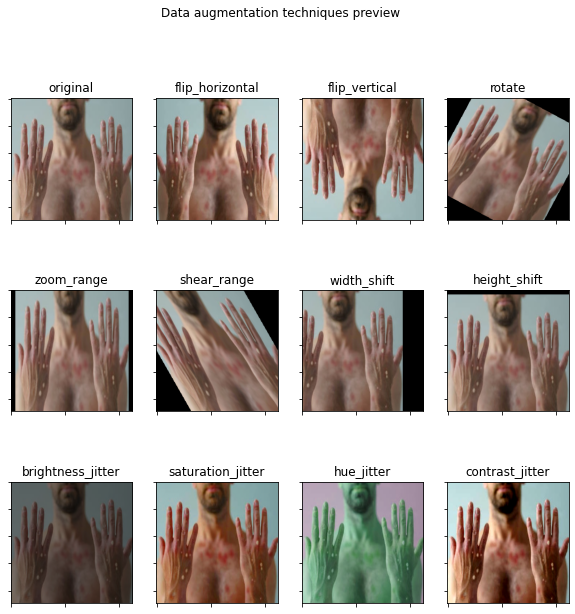

In [4]:
# Load and preprocess a sample image from the chickenpox category
img_path = 'data/MSID/Monkeypox/monkeypox69.png'
img = load_img(img_path,  target_size=(224, 224))

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))


# Plot each image in a subplot using a loop
for i, ax in enumerate(axs.flat):    
    augmented_image = augment_image(augmentations[i], img)
    
    # Plot the image in the current subplot
    ax.imshow(augmented_image)
    
    # Remove the tick labels from the current subplot
    ax.set_facecolor('white')
    ax.tick_params(colors='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Add a title to the current subplot
    ax.set_title(augmentations[i])
    
# Add a title to the figure
fig.suptitle('Data augmentation techniques preview')

# Show the plot
plt.show()
    

In [10]:
data_dir='data/MSID_BINARY'
save_dir='data/MSID_BINARY_AUG'

In [11]:
# Loop over the images in the original dataset
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        # Load the image
        
        img_path = os.path.join(subdir, file)        
        img = load_img(img_path)
        

        # Apply the augmentations
        for aug in augmentations:
            # Apply the augmentation function
            augmented_img = augment_image(aug, img)

            # Get the class name from the directory name
            class_name = os.path.basename(subdir)

            # Create the save directory if it doesn't exist
            save_subdir = os.path.join(save_dir, class_name)
            os.makedirs(save_subdir, exist_ok=True)

            # Define the filename for the augmented image
            filename = os.path.splitext(file)[0] + '_' + aug + '.jpg'

            # Save the augmented image
            save_path = os.path.join(save_subdir, filename)
            save_img(save_path, augmented_img)